## Uncertainity in Deep Learning

Taken from http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html#uncertainty-sense

Also see: https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/

In [1]:
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange
from ipywidgets import interact, fixed

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
def get_data(N, min_x, max_x):
    w, b = np.random.rand(2)
    def true_model(X):
        y = np.sin(np.exp(w * X + b))
        return y
    X_true = np.linspace(min_x, max_x, N)
    y_true = true_model(X_true)
    span = (max_x - min_x)
    scale = 0.3
    X_obs = min_x + span*scale + np.random.rand(N)*(span - 2*scale*span)
    y_obs = true_model(X_obs) + np.random.randn(N)*0.2
    return (X_obs, y_obs, X_true, y_true), (w, b, true_model)
    

In [4]:
N = 100
min_x, max_x = -10, 10
(X_obs, y_obs, X_true, y_true), (w, b, true_model) = get_data(N, min_x, max_x)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


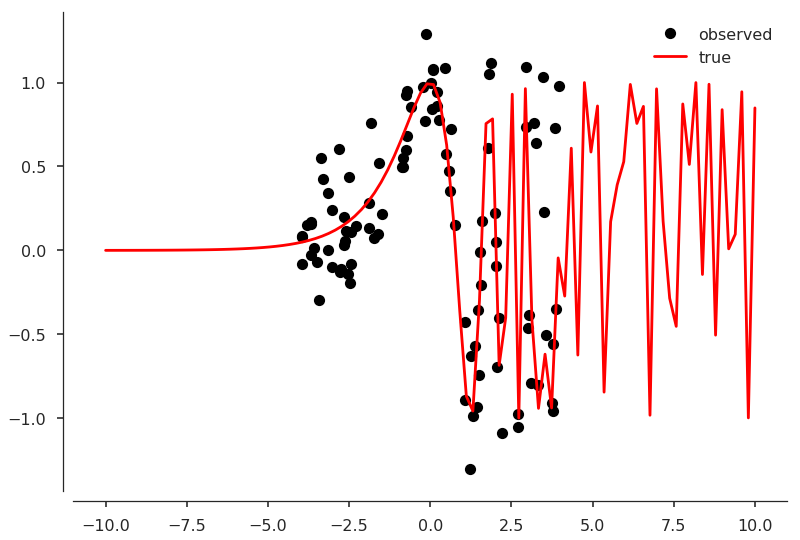

In [5]:
plt.plot(X_obs, y_obs, ls="none", marker="o", color="k", label="observed")
plt.plot(X_true, y_true, ls="-", color="r", label="true")
plt.legend()
sns.despine(offset=10)

In [6]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p=0.05, decay=0.001):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [7]:
model = SimpleModel(p=0.05, decay = 0.001)

In [8]:
def uncertainity_estimate(X, model, iters, l2=0.005):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1-model.dropout_p) / (2*N*model.decay)
    y_variance += (1/tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [9]:
y_mean, y_std = uncertainity_estimate(X_true, model, 200)

100%|██████████| 200/200 [00:00<00:00, 2615.15it/s]


In [10]:
def plot_model(model, iters=200, l2=1, n_std=2, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,1)
    y_mean, y_std = uncertainity_estimate(X_true, model, iters, l2=l2)
    
    ax.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
    ax.plot(X_true, y_true, ls="-", color="r", label="true")
    ax.plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax.fill_between(
            X_true,
            y_mean - y_std * ((i+1)/2),
            y_mean + y_std * ((i+1)/2),
            color="b",
            alpha=0.5**(i+1)
        )
    ax.legend()
    sns.despine(offset=10)
    return ax

100%|██████████| 200/200 [00:00<00:00, 2786.14it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


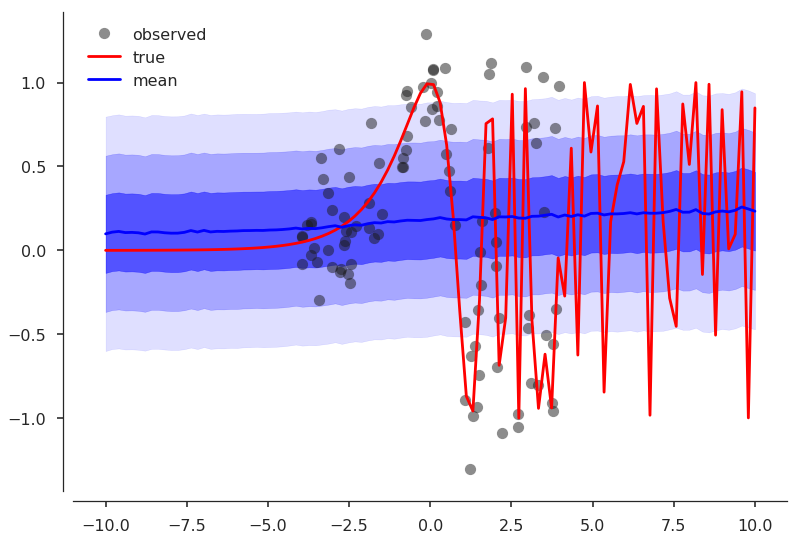

In [11]:
plot_model(model, n_std=3)

In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.001, momentum=0.9,
    weight_decay=model.decay)

In [13]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|██████████| 200/200 [00:00<00:00, 2823.57it/s]

loss=Variable containing:
 0.2782
[torch.FloatTensor of size 1]



/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


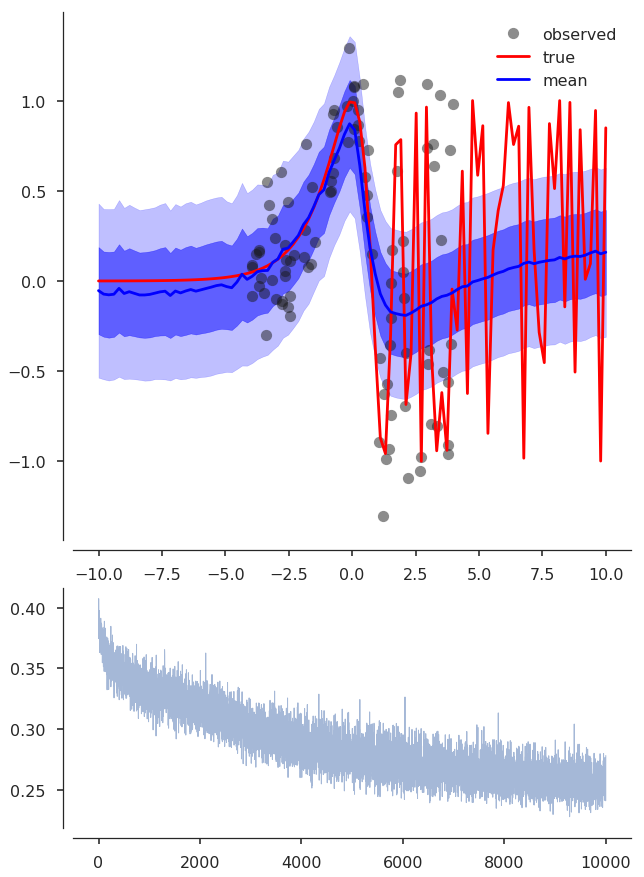

In [14]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = fit_model(model, optimizer)
    losses.append(loss.data.numpy()[0])
print("loss={}".format(loss))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
plot_model(model, ax=ax0)

100%|██████████| 200/200 [00:00<00:00, 2757.45it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


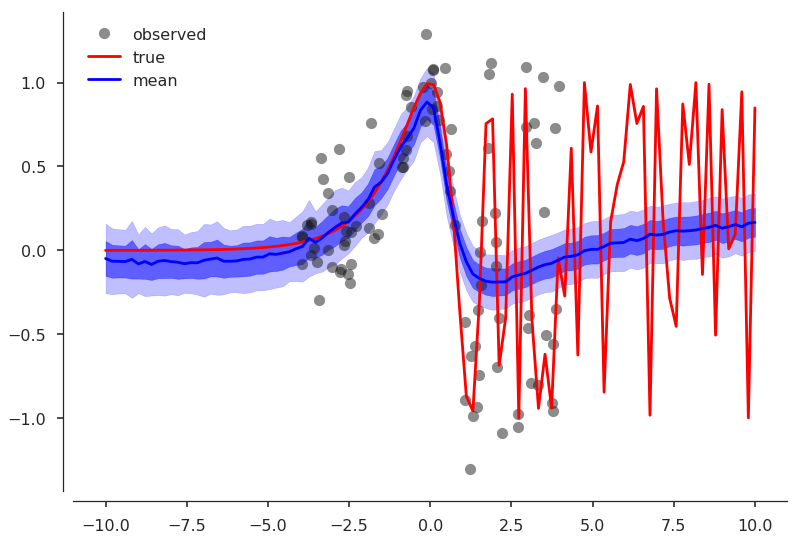

In [15]:
plot_model(model, l2=10)